# Lya DESI Mock Example

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Get quasar continuum from desisim

In [2]:
from desisim import templates as dst
# Instantiate
#reload(dst)
qso = dst.QSO()
continuum_flux, continuum_wave, metadata = qso.make_templates(nmodel=1,seed=123)
metadata['REDSHIFT'][0]

2.995343621831295

(3600, 7000)

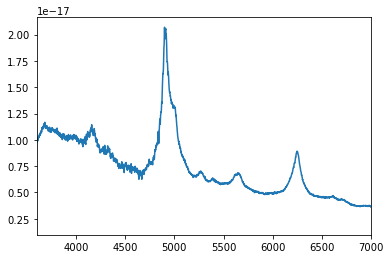

In [3]:
plt.plot(continuum_wave,continuum_flux[0])
plt.xlim(3600,7000)

#### Get random Lya forest skewer

zq 2.99534362183
lya_zq 4857.01938075


(4400, 5100)

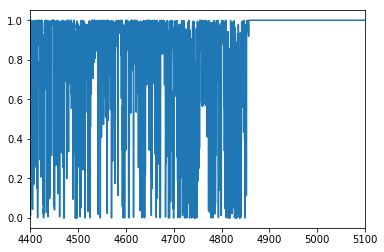

In [5]:
import lya_mock_p1d as mock
mock_maker = mock.MockMaker()
skewer_wave, skewer_flux = mock_maker.get_lya_skewer()
# only add absorption in the forest 
zq = metadata['REDSHIFT'].data[0]
print('zq',zq)
lya_zq = 1215.67 * (1+zq)
print('lya_zq',lya_zq)
no_forest = (skewer_wave > lya_zq)
skewer_flux[no_forest]=1.0
plt.plot(skewer_wave,skewer_flux)
plt.xlim(4400,5100)

#### Setup DESI simulator

In [6]:
import astropy.units as u
import specsim.simulator
desi = specsim.simulator.Simulator('desi', num_fibers=1)
# dummy simulation (we haven't passed source spectrum yet)
desi.simulate()
# get simulated wavelengths
wavelengths = desi.simulated['wavelength']
Npix = len(wavelengths)

#### Make DESI simulation with quasar spectrum as source

In [7]:
from desispec.interpolation import resample_flux
# interpolate forest transmission to simulation wavelength grid
skewer_interp_flux = resample_flux(wavelengths, skewer_wave, skewer_flux)

(3600, 6100)

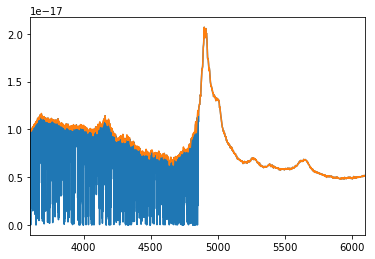

In [8]:
# interpolate mock quasar continuum to simulation wavelength grid
continuum_interp_flux = np.zeros((1,Npix))
continuum_interp_flux[0] = resample_flux(wavelengths, continuum_wave, continuum_flux[0]) 
# multiply quasar continuum by Lya forest skewer
mock_quasar_flux = continuum_interp_flux * skewer_interp_flux
plt.plot(wavelengths,mock_quasar_flux[0])
plt.plot(continuum_wave,continuum_flux[0])

plt.xlim(3600,6100)

In [9]:
# specsim uses astropy unities
mock_quasar_flux = mock_quasar_flux * u.erg / (u.Angstrom * u.s * u.cm ** 2)
# Feed quasar spectrum as source for simulator
desi.simulate(source_fluxes=mock_quasar_flux)
# generate also random noise
desi.generate_random_noise()

#### Make plot for each camera

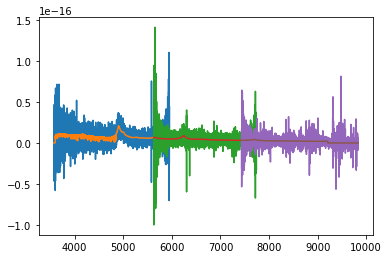

In [10]:
for output in desi.camera_output:
    sim_flux = output['observed_flux'].data
    sim_wave = output['wavelength'].data
    sim_noise = output['flux_calibration'] * output['random_noise_electrons']
    plt.plot(sim_wave,sim_flux[:,0] + sim_noise[:,0])
    plt.plot(sim_wave,sim_flux[:,0])    
    #plt.xlim(3550,4200)